# Deep Fake Detection Using LSTM CNN AND SELF ATTENTION

In [ ]:

import kagglehub
reubensuju_celeb_df_v2_path = kagglehub.dataset_download('reubensuju/celeb-df-v2')

print('Data source import complete.')


Data source import complete.


In [63]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import json
from torch.utils.data.sampler import WeightedRandomSampler

# DataSet Creation

In [64]:
df = pd.read_csv('/kaggle/input/celeb-df-v2/List_of_testing_videos.txt',delimiter=' ')
df.shape

(517, 2)

In [65]:
# TO SPLIT THE DATA EVENLY
def create_dataset_splits(base_path, output_path, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    real_videos = []
    fake_videos = []

    # Collect real videos
    for folder in ['Celeb-real', 'YouTube-real']:
        folder_path = os.path.join(base_path, folder)
        videos = [os.path.join(folder, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]
        real_videos.extend(videos)


    # Collect fake videos
    fake_folder = os.path.join(base_path, 'Celeb-synthesis')
    fake_videos = [os.path.join('Celeb-synthesis', f) for f in os.listdir(fake_folder) if f.endswith('.mp4')]

    #REMOVE AFTER TESTING
    real_videos = real_videos[:500]
    fake_videos = fake_videos[:500]

    class_counts = {
        'real': len(real_videos),
        'fake': len(fake_videos)
    }
    print(f"Real videos: {class_counts['real']}, Fake videos: {class_counts['fake']}")

    # Split each class separately
    splits_dict = {split: [] for split in ['train', 'val', 'test']}

    for videos, label in [(real_videos, 'real'), (fake_videos, 'fake')]:
        train_split, temp = train_test_split(videos, train_size=train_size, random_state=seed)
        relative_val_size = val_size / (val_size + test_size)
        val_split, test_split = train_test_split(temp, train_size=relative_val_size, random_state=seed)

        splits_dict['train'].extend(train_split)
        splits_dict['val'].extend(val_split)
        splits_dict['test'].extend(test_split)

    # this line creates an empty if output path is not existing already (Throws error if not executed)
    os.makedirs(output_path, exist_ok=True)

    with open(os.path.join(output_path, 'splits.json'), 'w') as f:
        json.dump({
            'splits': splits_dict,
            'class_counts': class_counts
        }, f)

    return splits_dict, class_counts

# **Why do we need a Sampler?**

Imagine your dataset has:

    2000 real videos

    500 fake videos

If you let PyTorch randomly pick videos, you’ll mostly get real ones, and the model might just learn to say “real” all the time because it sees real samples more often.

❗️To fix this, we use a WeightedRandomSampler: it picks each video based on a weight (probability). Videos from the minority class (fake) get higher weights so they’re picked more often.

In [66]:
#A PYTORCH DATASET THAT RETRIEVES THAT VIDEO DATA
class VideoDatasetSplit(Dataset):
    def __init__(self, base_path, split_path, split='train', sequence_length=15, transform=None):
      # Setting parameters
        self.base_path = Path(base_path)
        self.sequence_length = sequence_length
        self.transform = transform

        with open(os.path.join(split_path, 'splits.json'), 'r') as f:
            data = json.load(f)
            # Setting Parameters
            self.videos = data['splits'][split]
            self.class_counts = data['class_counts']

    def get_sampler(self):
        weights = []
        # Storing max number of samples from real and fake using class_counts(It stores counts of real and fake numbers in dataset).
        max_samples = max(self.class_counts.values())

        for video_path in self.videos:
            is_fake = 'synthesis' in video_path
            count = self.class_counts['fake'] if is_fake else self.class_counts['real']
            weight = max_samples / count
            weights.append(weight)

        # WeightedRandomSampler picks samples randomly, but weighted, helps balance classes during training
        # Sampler might look something like this for equal data(500 - 500) - [1.0, 1.0, 1.0, ---, 1.0]
        return WeightedRandomSampler(torch.DoubleTensor(weights), len(weights))

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = 1 if 'synthesis' in video_path else 0  # 1 for fake, 0 for real

        # Extract equal frames from the video using load_video function.
        frames = self.load_video(os.path.join(self.base_path, video_path))
        if self.transform:
            # Concatenates a sequence of tensors along a new dimension. (dim = 0 if not specified).
            frames = torch.stack([self.transform(frame) for frame in frames])

        # returns frames with label
        return frames, label

    def __len__(self):
        return len(self.videos)

    def load_video(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        # print("TOTAL FRAMES: ",total_frames)
        # Taking frame numbers evenly from 0 to total_frames - 1
        indices = np.linspace(0, total_frames-1, self.sequence_length, dtype=int)

        for frame_idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            else:
                frames.append(np.zeros(frames[-1].shape, dtype=np.uint8))
            # print(frames[-1].shape)

        cap.release()
        # print("Number of FRAMES: ",len(frames))
        return np.stack(frames)

def create_dataloaders(base_path, output_path,dim, batch_size=4, sequence_length=10):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((dim, dim)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    splits_dict, class_counts = create_dataset_splits(base_path, output_path)

    train_dataset = VideoDatasetSplit(base_path, output_path, 'train', sequence_length, transform)
    val_dataset = VideoDatasetSplit(base_path, output_path, 'val', sequence_length, transform)
    test_dataset = VideoDatasetSplit(base_path, output_path, 'test', sequence_length, transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_dataset.get_sampler(),
        num_workers=0,
        pin_memory=True
    )

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    return train_loader, val_loader, test_loader, class_counts

In [67]:
train_loader, val_loader, test_loader, class_counts = create_dataloaders('/kaggle/input/celeb-df-v2','/kaggle/working/splits',dim=112,batch_size=2,sequence_length=15)

Real videos: 500, Fake videos: 500


In [68]:
class_counts

{'real': 500, 'fake': 500}

## Visualizing

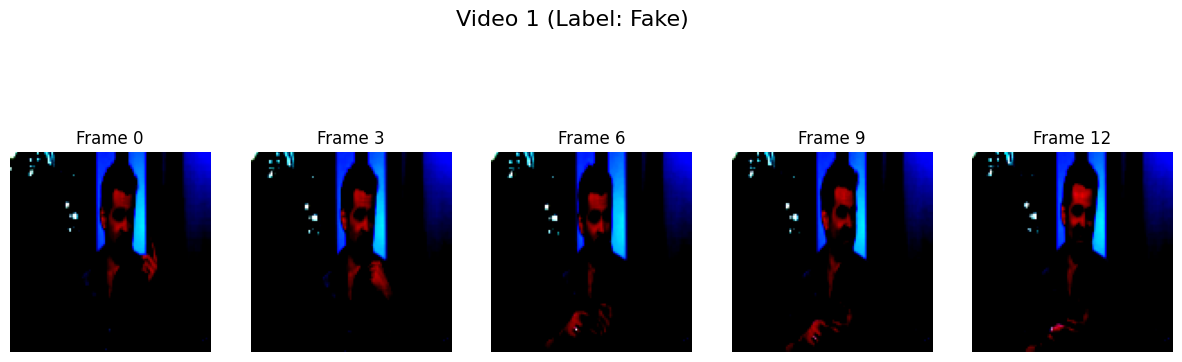

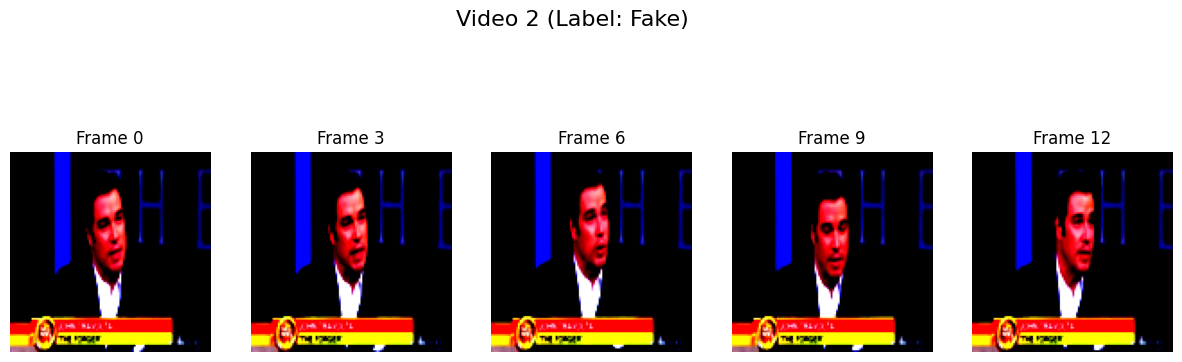

In [69]:
import matplotlib.pyplot as plt

def visualize_frames(data_loader, num_videos=2, num_frames=5):
    """
    Visualizes frames from videos in a batch.
    Args:
        data_loader: DataLoader object containing the video dataset.
        num_videos: Number of videos to visualize from the batch.
        num_frames: Number of frames to visualize per video.
    """
    # Fetch one batch of data
    batch = next(iter(data_loader))
    videos, labels = batch  # videos: [batch_size, sequence_length, C, H, W], labels: [batch_size]

    videos = videos[:num_videos]  # Take the first few videos
    labels = labels[:num_videos]

    for i, video in enumerate(videos):
        # Convert video tensor to numpy array and move channel to the last dimension
        video = video.permute(0, 2, 3, 1).numpy()  # Shape: [sequence_length, H, W, C]

        # Plot frames
        fig, axs = plt.subplots(1, num_frames, figsize=(15, 5))
        fig.suptitle(f"Video {i + 1} (Label: {'Fake' if labels[i] == 1 else 'Real'})", fontsize=16)

        for j in range(num_frames):
            frame_idx = int(j * (len(video) / num_frames))  # Select evenly spaced frames
            axs[j].imshow(video[frame_idx])
            axs[j].axis('off')
            axs[j].set_title(f"Frame {frame_idx}")

        plt.show()


visualize_frames(train_loader, num_videos=3, num_frames=5)


# Model Creation

In [70]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import wandb
import torch.nn.functional as F

class DynamicVideoClassifier(nn.Module):
    def __init__(self, backbone='resnet18', hidden_size=512, num_layers=2, dropout=0.3):
        super().__init__()

        # List of valid backbones
        self.valid_backbones = [
            'vgg16', 'resnet18', 'resnet50', 'densenet121', 'mobilenet_v2', 'inception_v3'
        ]

        # Ensure the provided backbone is valid
        if backbone not in self.valid_backbones:
            raise ValueError(f"Invalid backbone. Choose from {', '.join(self.valid_backbones)}")

        # Load the CNN backbone and get feature size
        self.backbone = getattr(models, backbone)(pretrained=True)
        avg_size = 1
        # print(self.backbone)
        # Adjust feature size based on the model architecture

        if backbone in ['resnet18', 'resnet50']:
            self.feature_size = self.backbone.fc.in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove fully connected layer
        elif backbone == 'vgg16':
            self.feature_size = self.backbone.classifier[0].in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1][0])  # Remove classifier
            avg_size = 7
        elif backbone == 'densenet121':
            self.feature_size = self.backbone.classifier.in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove classifier
        elif backbone == 'mobilenet_v2':
            self.feature_size = self.backbone.classifier[1].in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove classifier
        elif backbone == 'inception_v3':
            self.feature_size = self.backbone.AuxLogits.fc.in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove classifier

        self.avg_pool = nn.AdaptiveAvgPool2d((avg_size, avg_size))  # Applies average pooling over spatial dimensions (H, W)
        # LSTM for temporal features
        self.lstm = nn.LSTM(
            input_size=self.feature_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        # self.attention = nn.MultiheadAttention(hidden_size,2, dropout=dropout, batch_first=True)
        # self.layer_norm = nn.LayerNorm(hidden_size)

        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()


        # CNN feature extraction
        x = x.view(-1, c, h, w)
        # print('Input X: ',x.shape)
        x = self.backbone(x)
        x = self.avg_pool(x)
        # print('Output from CNN X: ',x.shape)
        x = x.view(batch_size, seq_len, -1)  # Reshape to (batch_size, seq_len, feature_size)

        # LSTM processing
        # print('Input LSTM: ',x.shape)
        lstm_out, _ = self.lstm(x)
        # print('Output LSTM: ',lstm_out.shape)

        # Attention mechanism
        # print('Input Att: ',lstm_out.shape)
        attention_weights = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)
        attended_features = torch.sum(attention_weights * lstm_out, dim=1)
        # print('Output Att: ',attended_features.shape)
        # attended_features, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
        # attended_features = self.layer_norm(lstm_out + attended_features)
        # attended_features = torch.mean(attended_features, dim=1)  # Average across sequence
        # print('Output Att: ',attended_features.shape)
        # Classification
        output = self.classifier(attended_features)
        # print("Output: ",output.shape)
        # print("SE: ",output.squeeze().shape)
        return output.squeeze()


In [71]:
from sklearn.metrics import accuracy_score

class VideoTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        learning_rate=1e-4,
        weight_decay=0.01,
        epochs=10,
        device='cuda',
        use_wandb=False
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.epochs = epochs
        self.use_wandb = use_wandb
        self.metrics = []

        # Loss function with class weighting
        pos_weight = self._calculate_pos_weight()
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        # Optimizer and scheduler
        self.optimizer = AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=epochs,
            eta_min=learning_rate/100
        )

        if use_wandb:
            self._init_wandb()

    def _calculate_pos_weight(self):
        total_pos = sum(1 for _, label in self.train_loader.dataset if label == 1)
        total_neg = len(self.train_loader.dataset) - total_pos
        return torch.tensor([total_neg / total_pos]).to(self.device)

    def _init_wandb(self):
        wandb.init(
            project="deepfake-detection",
            config={
                "architecture": self.model.__class__.__name__,
                "backbone": "resnet50",
                "epochs": self.epochs,
                "batch_size": self.train_loader.batch_size,
            }
        )

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        predictions, targets = [], []

        for batch_idx, (videos, labels) in enumerate(self.train_loader):
            videos, labels = videos.to(self.device), labels.to(self.device).float()

            self.optimizer.zero_grad()
            outputs = self.model(videos)
            # print(outputs.shape)
            # print(labels.shape)
            loss = self.criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            running_loss += loss.item()
            predictions.extend(outputs.detach().cpu().numpy())
            targets.extend(labels.cpu().numpy())


        metrics = self._calculate_metrics(predictions, targets)
        metrics['loss'] = running_loss / len(self.train_loader)
        print("Train Epoch Loss: ",metrics['loss'])
        return metrics

    def validate(self,mode='val'):
        self.model.eval()
        running_loss = 0.0
        predictions, targets = [], []
        loader = self.val_loader
        if mode == 'test':
            loader = self.test_loader
        with torch.no_grad():
            for videos, labels in loader:
                videos, labels = videos.to(self.device), labels.to(self.device).float()
                outputs = self.model(videos)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                predictions.extend(outputs.cpu().numpy())
                targets.extend(labels.cpu().numpy())
        # REMOVE
        # print("Validation:")
        # print((np.array(predictions) > 0.5).astype(int))
        # print(targets)
        metrics = self._calculate_metrics(predictions, targets)
        if mode == 'val':
            metrics['loss'] = running_loss / len(self.val_loader)
            print("Validation Epoch Loss: ",metrics['loss'])
        return metrics

    def _calculate_metrics(self, predictions, targets):
        predictions = np.array(predictions)
        targets = np.array(targets)

        # Convert probabilities to binary predictions
        binary_preds = (predictions > 0.5).astype(int)

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            targets, binary_preds, average='binary'
        )
        auc = roc_auc_score(targets, predictions)
        accuracy = accuracy_score(targets, binary_preds)

        return {
            'accuracy' : accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

    def train(self):
        best_val_auc = 0
        for epoch in range(self.epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.validate()
            self.scheduler.step()

            if val_metrics['auc'] > best_val_auc:
                best_val_auc = val_metrics['auc']
                torch.save(self.model.state_dict(), 'best_model.pth')

            metrics = {
                'train': train_metrics,
                'val': val_metrics,
                'epoch': epoch + 1
            }

            self._log_metrics(metrics)
        print("[Running on TEST SET]")
        print('-'*80)
        test_metrics = self.validate('test')
        print(test_metrics)

    def _log_metrics(self, metrics):
        print(f"Epoch {metrics['epoch']}/{self.epochs}")
        for phase in ['train', 'val']:
            print(f"{phase.capitalize()} - ", end="")
            phase_metrics = metrics[phase]
            metric_str = " | ".join(
                f"{k}: {v:.4f}" for k, v in phase_metrics.items()
            )
            print(metric_str)
        # WRITE HERE
        self.metrics.append(metrics)
        # Weight and Biases
        if self.use_wandb:
            wandb.log({
                f"{phase}_{k}": v
                for phase in ['train', 'val']
                for k, v in metrics[phase].items()
            })

In [72]:
def train_model(train_loader, val_loader,test_loader, config=None):
    valid_backbones = [
            'vgg16', 'resnet18', 'resnet50', 'densenet121', 'mobilenet_v2'
    ]
    if config is None:
        config = {
            'backbone': valid_backbones[2],
            'hidden_size': 512,
            'num_layers': 2,
            'dropout': 0.3,
            'learning_rate': 7.278416345265247e-05,
            'weight_decay': 0.01,
            'epochs': 10,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'use_wandb': False
        }

    model = DynamicVideoClassifier(
        backbone=config['backbone'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    )
    print(model)
    #Utilize Parallel computing
    model = torch.nn.DataParallel(model)

    trainer = VideoTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader= test_loader,
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        epochs=config['epochs'],
        device=config['device'],
        use_wandb=config['use_wandb']
    )

    trainer.train()
    return model , trainer.metrics

In [73]:
 model , metrics = train_model(train_loader, val_loader,test_loader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DynamicVideoClassifier(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Epoch Loss:  0.6962501533826192
Epoch 3/10
Train - accuracy: 0.5443 | precision: 0.5603 | recall: 0.2351 | f1: 0.3312 | auc: 0.5405 | loss: 0.6978
Val - accuracy: 0.5000 | precision: 0.0000 | recall: 0.0000 | f1: 0.0000 | auc: 0.4868 | loss: 0.6963
Train Epoch Loss:  0.6915488605839866
Validation Epoch Loss:  0.7035861678918203
Epoch 4/10
Train - accuracy: 0.5257 | precision: 0.5746 | recall: 0.2188 | f1: 0.3169 | auc: 0.5548 | loss: 0.6915
Val - accuracy: 0.5267 | precision: 0.5417 | recall: 0.3467 | f1: 0.4228 | auc: 0.5084 | loss: 0.7036
Train Epoch Loss:  0.6659735713686262
Validation Epoch Loss:  0.7351508057117462
Epoch 5/10
Train - accuracy: 0.6357 | precision: 0.7179 | recall: 0.4118 | f1: 0.5234 | auc: 0.6559 | loss: 0.6660
Val - accuracy: 0.4867 | precision: 0.4815 | recall: 0.3467 | f1: 0.4031 | auc: 0.4779 | loss: 0.7352
Train Epoch Loss:  0.6703063261508941
Validation Epoch Loss:  0.7435617935657501
Epoch 6/10
Train - accuracy: 0.6543 | precision: 0.6844 | recal

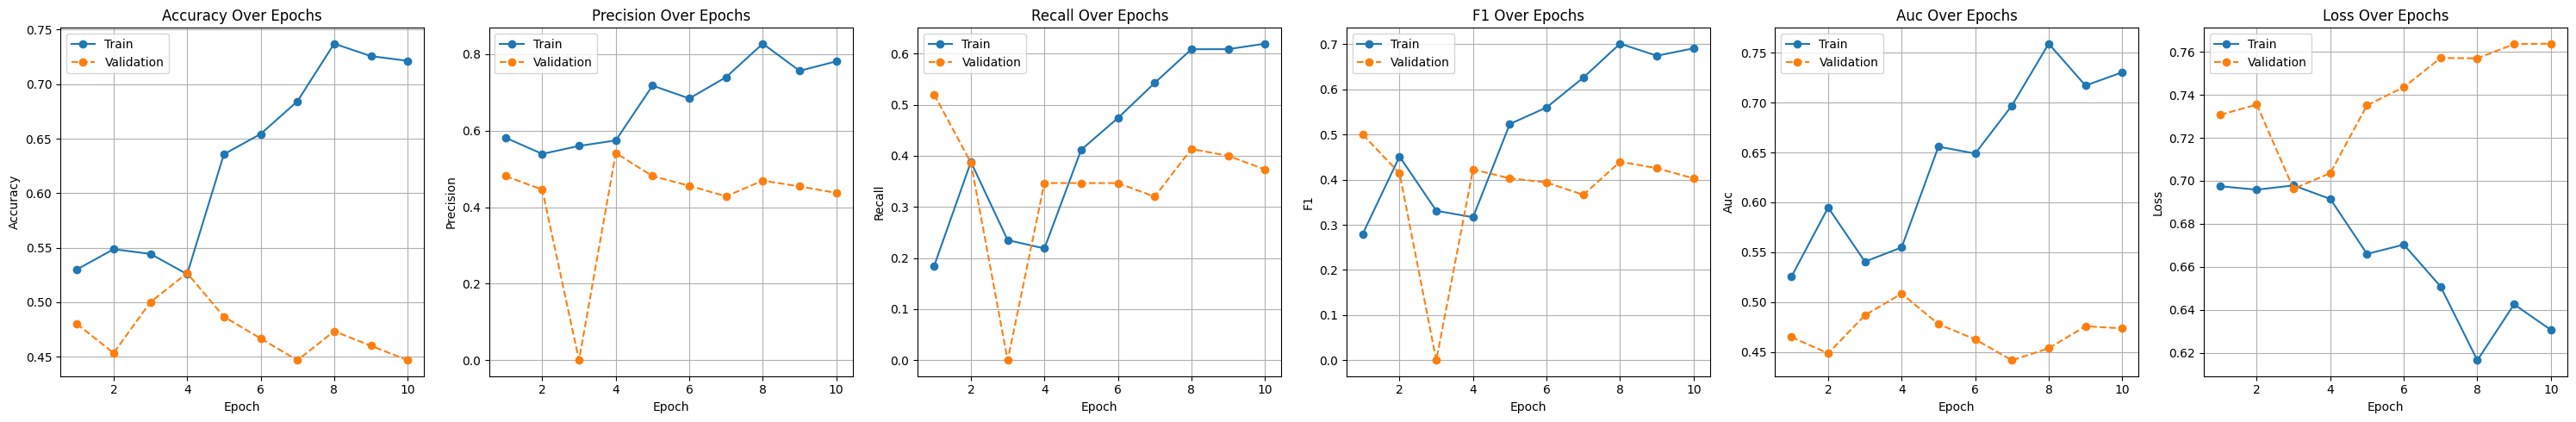

In [74]:
import matplotlib.pyplot as plt

def visualize_metrics(metrics):
    """
    Visualizes training and validation metrics over epochs.

    Args:
        metrics (list of dict): List containing dictionaries of training and validation metrics per epoch.
    """
    # Extract epochs, training, and validation metrics
    epochs = [entry['epoch'] for entry in metrics]
    train_metrics = {key: [entry['train'][key] for entry in metrics] for key in metrics[0]['train']}
    val_metrics = {key: [entry['val'][key] for entry in metrics] for key in metrics[0]['val']}

    # List of metric names
    metric_names = list(train_metrics.keys())

    # Set up the plots
    num_metrics = len(metric_names)
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5))
    if num_metrics == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot

    for i, metric_name in enumerate(metric_names):
        axes[i].plot(epochs, train_metrics[metric_name], label='Train', marker='o')
        axes[i].plot(epochs, val_metrics[metric_name], label='Validation', marker='o', linestyle='--')
        axes[i].set_title(f"{metric_name.capitalize()} Over Epochs")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric_name.capitalize())
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage

visualize_metrics(metrics)


Accuracy: 0.4867
              precision    recall  f1-score   support

        Real       0.49      0.56      0.52        75
        Fake       0.48      0.41      0.45        75

    accuracy                           0.49       150
   macro avg       0.49      0.49      0.48       150
weighted avg       0.49      0.49      0.48       150

Confusion Matrix:
[[42 33]
 [44 31]]


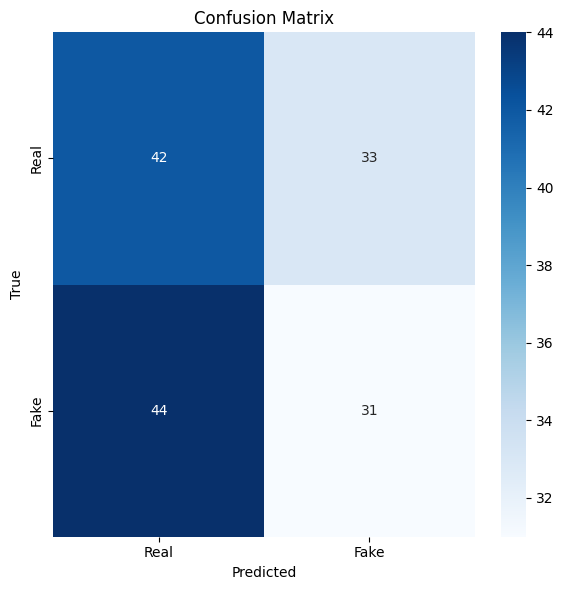

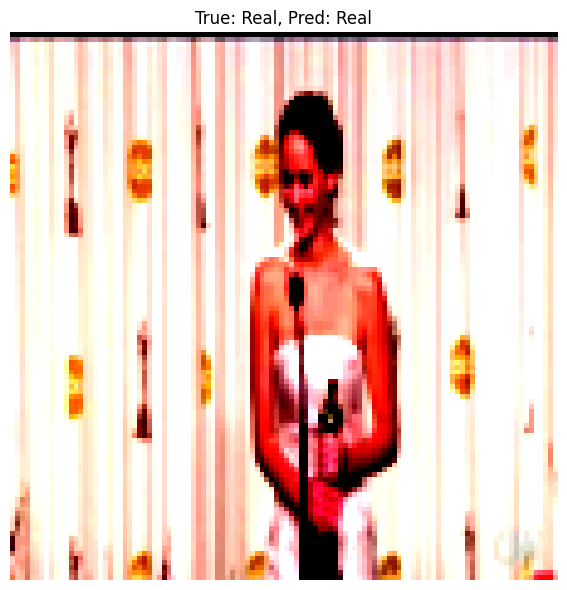

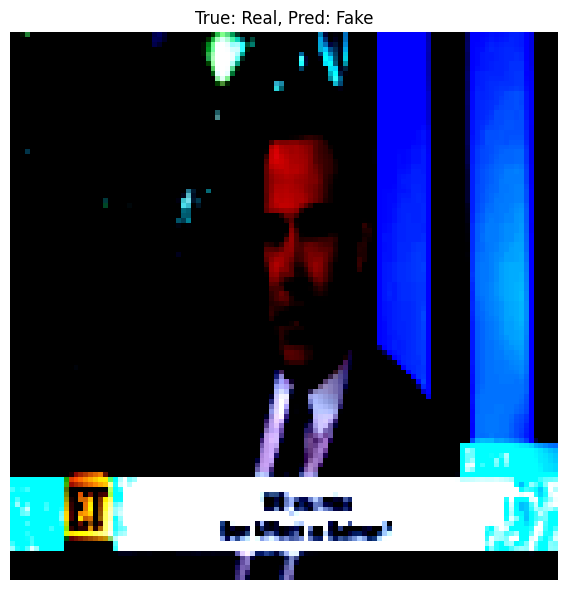

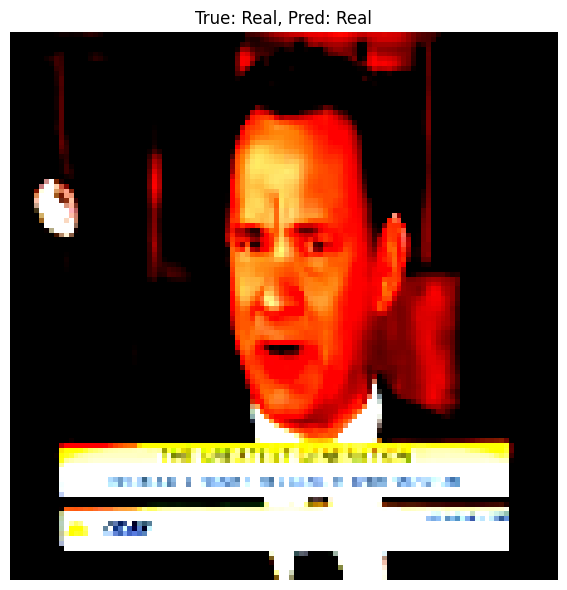

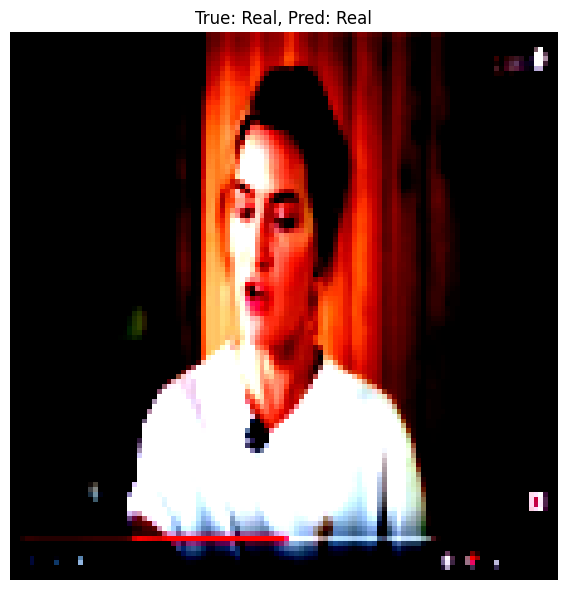

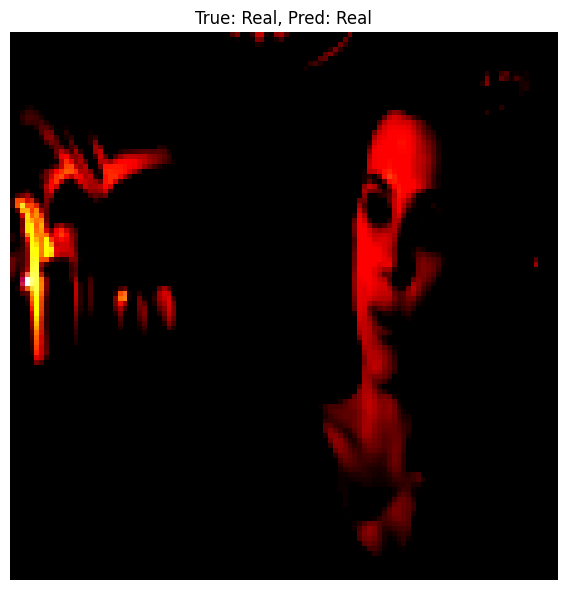

('              precision    recall  f1-score   support\n\n        Real       0.49      0.56      0.52        75\n        Fake       0.48      0.41      0.45        75\n\n    accuracy                           0.49       150\n   macro avg       0.49      0.49      0.48       150\nweighted avg       0.49      0.49      0.48       150\n',
 0.4866666666666667,
 array([[42, 33],
        [44, 31]]))

In [84]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model_with_metrics(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    all_images = []

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Move input data to the device (GPU or CPU)
            labels = labels.to(device)  # Move labels to the device

            # Get model predictions
            outputs = model(inputs)  # Forward pass
            preds = (outputs > 0.5).float()  # Convert to binary predictions (0 or 1)

            # Update correct predictions and total samples
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.append(preds.cpu().numpy())  # Collect predictions on CPU
            all_labels.append(labels.cpu().numpy())  # Collect true labels on CPU
            all_images.append(inputs.cpu().numpy())  # Collect images (or frames) on CPU

    # Flatten the list of predictions, labels, and images
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_images = np.concatenate(all_images)

    # Calculate accuracy manually
    accuracy = correct_predictions / total_samples
    print(f"Accuracy: {accuracy:.4f}")

    # Generate the classification report
    report = classification_report(all_labels, all_preds, target_names=['Real', 'Fake'])
    print(report)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()  # Ensures tight layout for the plot
    plt.show()

    # Display the first few predictions and corresponding images (for inspection)
    num_samples = 5  # Set how many sample images to display
    for i in range(num_samples):
        image = all_images[i][0]  # Assuming batch size = 1 (adjust accordingly for larger batches)
        label = all_labels[i]
        prediction = all_preds[i]

        # Plot the image and display predictions
        plt.figure(figsize=(6, 6))
        plt.imshow(np.transpose(image, (1, 2, 0)))  # Convert from CxHxW to HxWxC for displaying
        plt.axis('off')
        plt.title(f"True: {'Fake' if label == 1 else 'Real'}, Pred: {'Fake' if prediction == 1 else 'Real'}")
        plt.tight_layout()  # Ensures tight layout for the image plot
        plt.show()

    return report, accuracy, cm

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move model to the appropriate device
evaluate_model_with_metrics(model, test_loader, device)